## 스마트 공장의 제어 시스템 구추을 위한 제품 품질 분류 AI모델 개발
### 생산된 제품이 적정 기준을 충족하는지 판단하고 분류하는 AI모델

### 라이브러리 임포트

In [102]:
import numpy as np
import pandas as pd
import random
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix # 혼동행렬
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # f1 스코어
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

### 데이터로드

In [104]:
train = pd.read_csv('C:/Users/jihun/Dacon/SmartFactory/train.csv')
test = pd.read_csv('C:/Users/jihun/Dacon/SmartFactory/test.csv')

### 데이터정보
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 제품 품질 상태(Target)
-  0 : 적정 기준 미달(부적합)
-  1 : 적합
-  2 : 적정 기준 초과(부적합)
- 
- Y_Quality : 제품 품질 관련 정량적 수치
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE종류 ('T010305', 'T010306','T050304', 'T050307', 'T100304', 'T100306',  6개의 LINE종류 존재 )
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31, 'O_31','T_31' 존재)
- X_1~X_2875 : 공정 과정에서 추출되어 비식별화된 변수 

### 데이터정보확인

In [4]:
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Columns: 2881 entries, PRODUCT_ID to X_2875
dtypes: float64(2876), int64(1), object(4)
memory usage: 13.1+ MB


- 597개, 매우많은 특징

In [6]:
#598개의 행(제품개수), 2881의 열(제품특징?)
train.shape

(598, 2881)

In [7]:
train.isnull().sum()

PRODUCT_ID      0
Y_Class         0
Y_Quality       0
TIMESTAMP       0
LINE            0
             ... 
X_2871        499
X_2872        598
X_2873        598
X_2874        598
X_2875        598
Length: 2881, dtype: int64

In [8]:
test.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 원본 데이터 그래프 시각화

Text(0.5, 1.0, 'Y_Class')

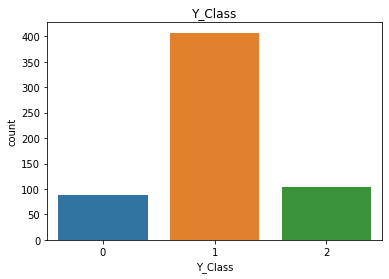

In [9]:
sns.countplot(data = train, x = 'Y_Class')
plt.title('Y_Class')

#### 적합(1) 부적합(0,2) 적합이 부적합보다 더 많다. 적합으로 판별할 가능성 높아짐

Text(0.5, 1.0, 'Y_Quality by LINE')

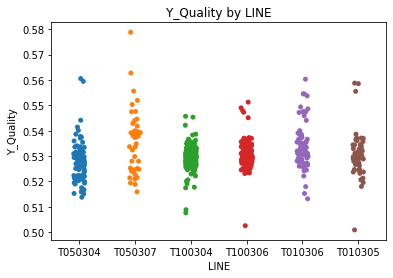

In [10]:
sns.stripplot(x="LINE", y="Y_Quality", data=train, jitter=True)
plt.title('Y_Quality by LINE')

<AxesSubplot:xlabel='PRODUCT_CODE', ylabel='Y_Quality'>

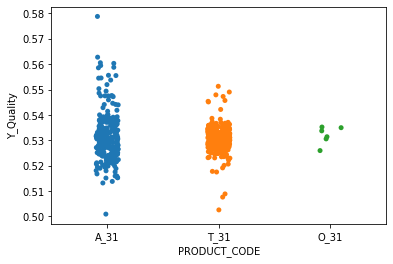

In [11]:
sns.stripplot(x="PRODUCT_CODE", y="Y_Quality", data=train, jitter=True)

<AxesSubplot:xlabel='Y_Class', ylabel='Y_Quality'>

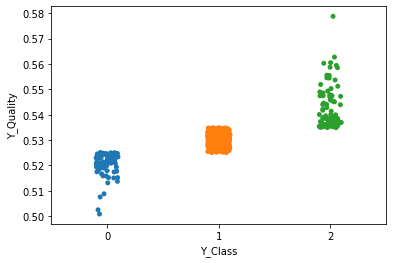

In [12]:
sns.stripplot(x="Y_Class", y="Y_Quality", data=train, jitter=True)

- 0 범위 : 0.500856 ~ 0.525067
- 1 범위 : 0.525086 ~ 0.534843
- 2 범위 : 0.534951 ~ 0.578841

<AxesSubplot:xlabel='LINE', ylabel='Y_Quality'>

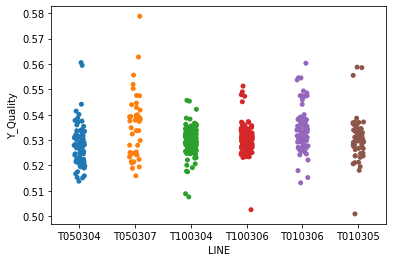

In [13]:
sns.stripplot(x="LINE", y="Y_Quality", data=train, jitter=True)

### Data Pre-Processing

In [14]:
train_scaler = train.iloc[:,6:]
test_scaler = test.iloc[:,4:]

In [15]:
train_scaler.head(3)

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN


In [16]:
test_scaler.head(3)

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,52.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()
Scaler.fit(train_scaler)

Train_scaler = Scaler.transform(train_scaler)
Test_scaler = Scaler.transform(test_scaler)

C:\Anaconda\envs\jh\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Anaconda\envs\jh\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [18]:
train.iloc[:,6:] = Train_scaler
test.iloc[:,4:] = Test_scaler

- (1) Y_Quality

In [105]:
x_train = train.drop(columns=['PRODUCT_ID', 'Y_Class', 'TIMESTAMP', 'Y_Quality'])
y_train = train['Y_Quality']

x_test = test.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [106]:
y_train

0      0.533433
1      0.541819
2      0.531267
3      0.537325
4      0.531590
         ...   
593    0.526546
594    0.524022
595    0.521289
596    0.531375
597    0.533702
Name: Y_Quality, Length: 598, dtype: float64

- (2) Y_Class

In [20]:
x_train_1 = train.drop(columns=['PRODUCT_ID', 'Y_Class', 'TIMESTAMP', 'Y_Quality'])
y_train_1 = train['Y_Class']

x_test_1 = test.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

#### 결측값 보간

In [107]:
x_train = x_train.fillna(0)
x_test = x_test.fillna(0)

In [22]:
x_train_1 = x_train_1.fillna(0)
x_test_1 = x_test_1.fillna(0)

#### StandardSclaer

### LabelEncoder

In [108]:
#(1)

col = ['LINE','PRODUCT_CODE']

for i in col:
    #LabelEncoder 객체생성
    encoder = LabelEncoder()
    #encoder객체 x_train 학습
    encdoer = encoder.fit(x_train[i])
    #x_trian데이터에 변환 숫자를 다시 저장
    x_train[i] = encoder.transform(x_train[i])
    
    for label in np.unique(x_test[i]):
        if label not in encoder.classes_: #unseen label 데이터인경우 
            encoder.classes_ = np.append(encoder.classes_, label)
    x_test[i] = encoder.transform(x_test[i])
print('Done.')

Done.


In [24]:
#(2)
col = ['LINE', 'PRODUCT_CODE']

for i in col:
    #LabelEncoder 객체생성
    encoder = LabelEncoder()
    #encoder객체 x_train 학습
    encdoer = encoder.fit(x_train_1[i])
    #x_trian데이터에 변환 숫자를 다시 저장
    x_train_1[i] = encoder.transform(x_train_1[i])
    
    for label in np.unique(x_test_1[i]):
        if label not in encoder.classes_: #unseen label 데이터인경우 
            encoder.classes_ = np.append(encoder.classes_, label)
    x_test_1[i] = encoder.transform(x_test_1[i])
print('Done.')

Done.


- 인코딩 전 LINE = T010305, T010306, T050304, T050307, T100304, T100306
- 인코딩 후 LINE = 0, 1, 2, 3, 4, 5

- 인코딩 전 PRODUCT_CODE : A_31, O_31, T_31
- 인코딩 후 PRODUCT_CODE : 0, 1, 2

### 모델링

### Y_Quality

In [141]:
model = KNeighborsRegressor(n_neighbors = 7, weights = 'distance')
model.fit(x_train,y_train)

pred = model.predict(x_test)

In [142]:
pred

array([0.53006121, 0.53022212, 0.53001855, 0.53755495, 0.53751978,
       0.52950541, 0.52958627, 0.52025238, 0.52543997, 0.52957444,
       0.53015548, 0.52827667, 0.5277814 , 0.53696417, 0.53223288,
       0.52970795, 0.52997449, 0.52962992, 0.5299694 , 0.52996887,
       0.52958687, 0.52996868, 0.52958644, 0.52871863, 0.52871865,
       0.52913253, 0.52996917, 0.5297764 , 0.5306771 , 0.52996958,
       0.5328808 , 0.52996983, 0.53288221, 0.52997007, 0.52997028,
       0.53064444, 0.53946662, 0.53098375, 0.53325136, 0.52724225,
       0.52728104, 0.54010635, 0.5298254 , 0.52997074, 0.52997072,
       0.52997126, 0.52997127, 0.52195364, 0.52997118, 0.52195549,
       0.52997145, 0.52195462, 0.52025238, 0.52025238, 0.52025238,
       0.52207732, 0.52997188, 0.52997214, 0.52214248, 0.52219067,
       0.52219391, 0.53120317, 0.52338254, 0.5617127 , 0.52179484,
       0.52952476, 0.52294059, 0.52997299, 0.52169104, 0.52177328,
       0.52177717, 0.53430553, 0.53421636, 0.5218282 , 0.52997

In [120]:
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split

model_names = ['Linear Regression', 'Lasso', 'Suport Vactor', 'K-Neighbor', 'Random Forest', 'ElasticNet']
models = []
models.append(LinearRegression())
models.append(Lasso(random_state=7))
models.append(SVR(kernel = 'rbf', gamma='scale'))
models.append(KNeighborsRegressor(n_neighbors = 7, weights = 'distance'))
models.append(RandomForestRegressor(random_state=7))
models.append(ElasticNet(random_state=7))

x_train_model, x_test_model, y_train_model, y_test_model = train_test_split(x_train, y_train, test_size=0.2, random_state=7)

for i in range(len(models)):
    print(models[i])

LinearRegression()
Lasso(random_state=7)
SVR()
KNeighborsRegressor(n_neighbors=7, weights='distance')
RandomForestRegressor(random_state=7)
ElasticNet(random_state=7)


##### 교차검증

In [121]:
from sklearn.model_selection import cross_val_score

rmse_list = []
for i in range(len(models)):
    model_name = model_names[i]
    print(model_name)
    model = models[i] 
    # K-fold cross validation
    nmse = cross_val_score(model, x_train_model, y_train_model, scoring = 'neg_mean_squared_error', cv=6)
    print('nmse : {}'.format(nmse))
    rmse = np.sqrt(-1*nmse)
    print('rmse : {}'.format(rmse))
    avg_rmse = (sum(rmse)-max(rmse)-min(rmse)/len(rmse)-2)
    rmse_list.append(avg_rmse)
    print(rmse_list)


Linear Regression
nmse : [-2.73795250e-04 -1.39782213e-04 -2.47405163e-04 -9.35076314e-05
 -1.30359952e-04 -3.85625108e-03]
rmse : [0.01654676 0.01182295 0.01572912 0.00966993 0.01141753 0.06209872]
[-1.9364253623921484]
Lasso


C:\Anaconda\envs\jh\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00783988840656828, tolerance: 1.9893578931462843e-06
  positive)
C:\Anaconda\envs\jh\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007658710156109537, tolerance: 1.9376330992701592e-06
  positive)
C:\Anaconda\envs\jh\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007443882909431785, tolerance: 1.8913351626263828e-06
  positive)
C:\Anaconda\envs\jh\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

nmse : [-2.98409289e-05 -3.50001559e-05 -4.02619546e-05 -5.49991951e-05
 -3.05969486e-05 -4.40301408e-05]
rmse : [0.00546269 0.00591609 0.00634523 0.00741614 0.00553145 0.00663552]
[-1.9364253623921484, -1.9710194665675975]
Suport Vactor
nmse : [-1.35017606e-04 -1.40334602e-04 -1.49086186e-04 -8.12066312e-05
 -1.13864423e-04 -1.19601858e-04]
rmse : [0.01161971 0.01184629 0.01221009 0.00901147 0.01067073 0.01093626]
[-1.9364253623921484, -1.9710194665675975, -1.947417450700139]
K-Neighbor
nmse : [-3.58768322e-05 -5.04524138e-05 -4.28607842e-05 -5.50801534e-05
 -3.43611832e-05 -3.92905718e-05]
rmse : [0.00598973 0.00710299 0.00654681 0.0074216  0.00586184 0.00626822]
[-1.9364253623921484, -1.9710194665675975, -1.947417450700139, -1.9692073847750082]
Random Forest
nmse : [-2.37767753e-05 -3.59530377e-05 -2.37566171e-05 -4.91938849e-05
 -2.58365856e-05 -2.61017556e-05]
rmse : [0.00487614 0.00599609 0.00487408 0.00701384 0.00508297 0.00510899]
[-1.9364253623921484, -1.9710194665675975, -1.9

C:\Anaconda\envs\jh\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007487233442741693, tolerance: 1.9893578931462843e-06
  positive)
C:\Anaconda\envs\jh\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007267085804261885, tolerance: 1.9376330992701592e-06
  positive)
C:\Anaconda\envs\jh\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007033328991870703, tolerance: 1.8913351626263828e-06
  positive)
C:\Anaconda\envs\jh\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

nmse : [-2.86830595e-05 -3.49689658e-05 -4.09353940e-05 -5.12988877e-05
 -3.15833769e-05 -4.58712267e-05]
rmse : [0.00535566 0.00591346 0.00639808 0.00716232 0.00561991 0.00677283]
[-1.9364253623921484, -1.9710194665675975, -1.947417450700139, -1.9692073847750082, -1.9748740834097744, -1.9708326799765297]


C:\Anaconda\envs\jh\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0068924551833074174, tolerance: 1.9190426157861705e-06
  positive)


In [123]:
rmse_list

[-1.9364253623921484,
 -1.9710194665675975,
 -1.947417450700139,
 -1.9692073847750082,
 -1.9748740834097744,
 -1.9708326799765297]

In [135]:
model_idx = np.argmin(rmse_list)
model_idx

4

In [137]:
def MAPE(clf, x, y):
    pred = clf.predict(x)
    y += 0.1
    return 100*np.mean(np.abs((y-pred)/y))

def RMSE(clf, x, y):
    pred = clf.predict(x)
    return np.sqrt(np.mean(np.square(y-pred)))

model_idx = np.argmin(rmse_list)
model = models[model_idx]
model.fit(x_train_model, y_train_model)
mape = MAPE(model, x_test_model, y_test_model)
rmse = RMSE(model, x_test_model, y_test_model)

In [138]:
comparsion = pd.DataFrame({'prediction': rmse, 'ground_truth' : y_test_model.values.ravel()})
print(comparsion)

     prediction  ground_truth
0       0.10105      0.637560
1       0.10105      0.621259
2       0.10105      0.626948
3       0.10105      0.621341
4       0.10105      0.630900
..          ...           ...
115     0.10105      0.658770
116     0.10105      0.629567
117     0.10105      0.631503
118     0.10105      0.625525
119     0.10105      0.654562

[120 rows x 2 columns]


In [49]:
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [10, 100, 200, 300],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestRegressor(random_state = 7, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(x_train_1, y_train_1)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

KeyboardInterrupt: 

In [145]:
Y_Quality_pred = pred

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [146]:
Y_Quality_pred = pd.DataFrame({'Y_Quality' : Y_Quality_pred})
Y_Quality_pred

,Y_Quality
0,0.530061
1,0.530222
2,0.530019
3,0.537555
4,0.537520
...,...
305,0.531812
306,0.530371
307,0.531811
308,0.531811


In [128]:
def trans_012(data) : 
        if(data < 0.525067) :
            return 0
        elif(data > 0.534951):
            return 2
        else :
            return 1

In [147]:
for i in range(len(pred)):
    pred[i] = trans_012(pred[i])
    
pred1 = pd.DataFrame({'Y_Class' : pred})
pred = pred1.astype({'Y_Class' : 'int32'})
pred

,Y_Class
0,1
1,1
2,1
3,2
4,2
...,...
305,1
306,1
307,1
308,1


In [148]:
pred.value_counts()

Y_Class
1          260
0           35
2           15
dtype: int64

In [34]:
Quality_pred = pd.concat([Y_Quality_pred, pred], axis=1)

In [35]:
Quality_pred

,Y_Quality,Y_Class
0,0.531429,1
1,0.534221,1
2,0.532991,1
3,0.526929,1
4,0.530403,1
...,...,...
305,0.528357,1
306,0.528765,1
307,0.528731,1
308,0.528737,1


### Y_Class

In [36]:
model1 = RandomForestClassifier(random_state=7)
model1.fit(x_train_1,y_train_1)
pred_1 = model1.predict(x_test_1)


In [37]:
pred_1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,

In [38]:
pred_1 = pd.DataFrame({'Y_Class' : pred_1})

In [39]:
pred_1.value_counts()

Y_Class
1          273
0           35
2            2
dtype: int64

In [40]:
Y_Quality_df = pd.concat([Y_Quality_pred,pred],axis=1 )

In [41]:
Y_Quality_df_0 = Y_Quality_df[Y_Quality_df['Y_Class']==0]
Y_Quality_df_1 = Y_Quality_df[Y_Quality_df['Y_Class']==1]
Y_Quality_df_2 = Y_Quality_df[Y_Quality_df['Y_Class']==2]

In [42]:
Y_Quality_df_1

,Y_Quality,Y_Class
0,0.531429,1
1,0.534221,1
2,0.532991,1
3,0.526929,1
4,0.530403,1
...,...,...
305,0.528357,1
306,0.528765,1
307,0.528731,1
308,0.528737,1


In [43]:
Y_Quality_df_t = pd.concat([Y_Quality_df_0,Y_Quality_df_1,Y_Quality_df_2],axis=1 )

In [44]:
Y_Quality_df_t

,Y_Quality,Y_Class,Y_Quality,Y_Class,Y_Quality,Y_Class
0,NaN,NaN,0.531429,1.0,NaN,NaN
1,NaN,NaN,0.534221,1.0,NaN,NaN
2,NaN,NaN,0.532991,1.0,NaN,NaN
3,NaN,NaN,0.526929,1.0,NaN,NaN
4,NaN,NaN,0.530403,1.0,NaN,NaN
...,...,...,...,...,...,...
305,NaN,NaN,0.528357,1.0,NaN,NaN
306,NaN,NaN,0.528765,1.0,NaN,NaN
307,NaN,NaN,0.528731,1.0,NaN,NaN
308,NaN,NaN,0.528737,1.0,NaN,NaN


In [45]:
ppp = Y_Quality_df[(Y_Quality_df['Y_Class']==2) & (Y_Quality_df['Y_Class']==1)].index

In [149]:
submit = pd.read_csv('C:/Users/jihun/Dacon/SmartFactory/sample_submission.csv')

In [150]:
submit['Y_Class'] = pred

In [151]:
submit.to_csv('C:/Users/jihun/Dacon/SmartFactory/Result_submission.csv', index=False)